In [1]:
# ! pip install transformers

In [2]:
import pandas as pd
import numpy as np
import networkx as nx

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

from transformers import BertModel, BertTokenizer
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

import matplotlib.pyplot as plt


## Загрузка и предварительная обработка данных

Загрузим дерево категорий и построим граф:

In [3]:
categories_tree = pd.read_csv('/home/voland/vscode/Jupyter_projects/kazanexpress-categorization-of-product/categories_tree.csv')
categories_tree

,id,title,parent_id
0,1,Все категории,0
1,114,Урбеч,1913
2,115,Варенье и джемы,328
3,128,Сухие завтраки,2475
4,131,Масла,2475
...,...,...,...
3365,14555,Насадки и запчасти,11691
3366,14556,Швейные машины,10062
3367,14557,Матрасы,2894
3368,14558,Ледянки и тюбинги,10092


In [4]:
G = nx.DiGraph()
G.add_edges_from(categories_tree[['parent_id', 'id']].values)

Визуализируем структуру каталога:

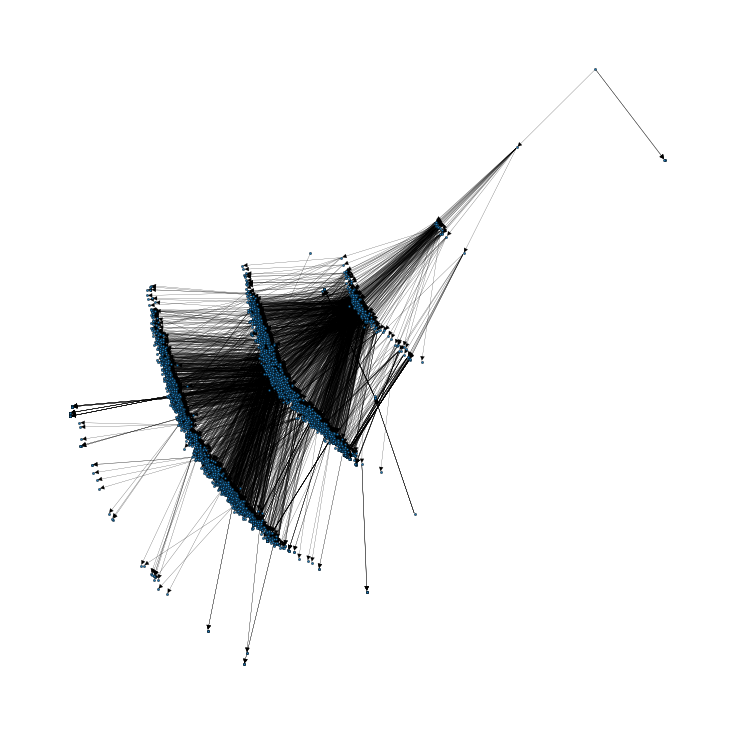

In [5]:
pos = nx.kamada_kawai_layout(G)
plt.figure(figsize=(10, 10))
nx.draw(G,
        pos=pos,
        width=0.2,
        linewidths=0.4,
        edgecolors='black',
        node_size=5,
       )

### Загрузка и предобработка данных

In [6]:
def prepare_data(data):
  data.fillna('', inplace=True)
  data['text'] = data['title'].str.lower() + '. ' + data['short_description'].str.lower() + '. ' + data['name_value_characteristics'].str.lower()
  data['len_text'] = train['text'].apply(lambda x: len(x))

Загрузим тренировочный датасет:

In [7]:
train = pd.read_parquet('/home/voland/vscode/Jupyter_projects/kazanexpress-categorization-of-product/train.parquet')
prepare_data(train)
train.head()

,id,title,short_description,name_value_characteristics,rating,feedback_quantity,category_id,text,len_text
0,1267423,Muhle Manikure Песочные колпачки для педикюра ...,Muhle Manikure Колпачок песочный шлифовальный ...,,0.000000,0,2693,muhle manikure песочные колпачки для педикюра ...,201
1,128833,"Sony Xperia L1 Защитное стекло 2,5D",,,4.666667,9,13408,"sony xperia l1 защитное стекло 2,5d. .",39
2,569924,"Конверт для денег Прекрасная роза, 16,5 х 8 см","Конверт для денег «Прекрасная роза», 16,5 × 8 см",,5.000000,6,11790,"конверт для денег прекрасная роза, 16,5 х 8 см...",98
3,1264824,Серьги,,,0.000000,0,14076,серьги. .,10
4,1339052,Наклейки на унитаз для туалета на крышку бачок...,"Водостойкая, интересная наклейка на унитаз раз...",,0.000000,0,12401,наклейки на унитаз для туалета на крышку бачок...,148


Посмотрим количество категорий в 'category_id':

In [8]:
num_classes =  len(set(train.category_id.values))
print('Общее количество конечных категорий: {}'.format(num_classes))

Общее количество конечных категорий: 1231


Проверим, что все целевые категории в тренировочном датасете являются "листовыми" (из них нет ветвления на более мелкие категории):

In [9]:
categories = set(train.category_id.values)
list_nodes_test = []
for node in set(categories):
    if len(list(G[node])) > 0:
        list_nodes_test.append(node)
if len(list_nodes_test) == 0:
    print('Все целевые категории являются листовыми.')
else:
    print('В целевых метках присутствуют нелистовые категории:')
    print(list_nodes_test)

Все целевые категории являются листовыми.


Распределение количества элементов в каждом классе:

<AxesSubplot:>

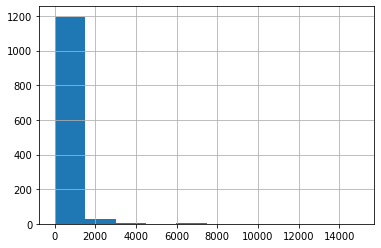

In [10]:
train['category_id'].value_counts().hist()

<AxesSubplot:>

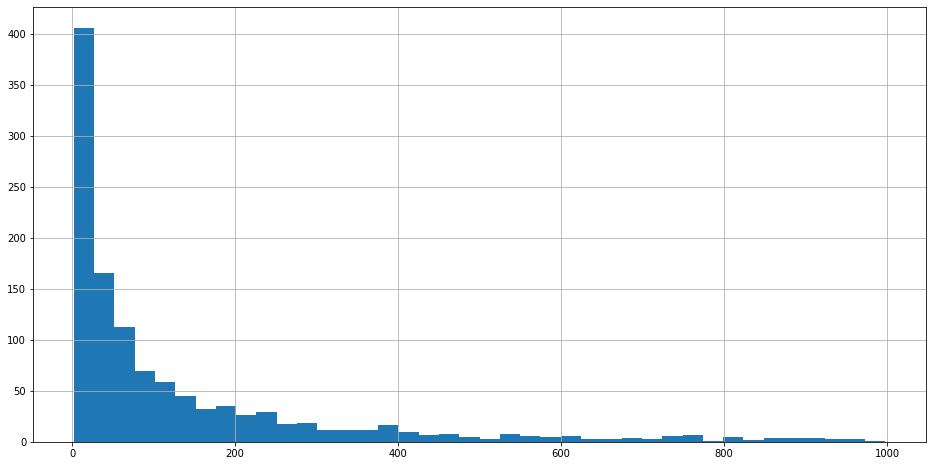

In [11]:
category_cnt = train['category_id'].value_counts().reset_index()
category_cnt[category_cnt['category_id'] < 1000]['category_id'].hist(bins=40, figsize=(16, 8))

Видим, что достаточно большое количество категорий (более 500) содержит малое количество примеров в обучающей выборке (менее 50). Почти 200 категорий содержат менее 10 примеров.

Посмотрим на распределение длительности текста:

<AxesSubplot:>

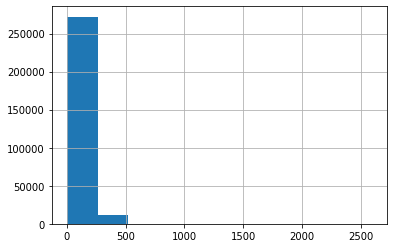

In [12]:
train['len_text'].hist()

Большая часть описаний товаров составляет до 250 символов

Для дальнейшей работы модели переведем целевые категории в one-hot формат:

In [13]:
train['category_id_obj'] = train['category_id'].astype('category')
train_cat = pd.get_dummies(train[['category_id_obj']], prefix='', prefix_sep='', sparse = False)
train = pd.concat([train, train_cat], axis = 1)
target_names = train_cat.columns
target_names = list(train_cat.columns)

Разобьем выборку на тестовые и валидационные данные

In [14]:
df_train, df_val = train_test_split(train, test_size=0.1, stratify=train.category_id, random_state=42)

# Построение нейронной сети

In [15]:
from models import KEDataset, BertClasifyByCLS
from utils import seed_everything, get_path, get_hF, train_epoch, val_epoch, infer, infer_single, train_model

In [17]:
seed_everything(42)
max_length = 512
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

tokenizer = BertTokenizer.from_pretrained("cointegrated/rubert-tiny2")
bert = BertModel.from_pretrained("cointegrated/rubert-tiny2")
model = BertClasifyByCLS(bert, emd_size=312, num_classes=num_classes).to(device)

train_ds = KEDataset(df_train, tokenizer, max_length, target_names=target_names)
train_loader = DataLoader(train_ds, shuffle=True, drop_last=True, batch_size=32)
val_ds = KEDataset(df_val, tokenizer, max_length, target_names=target_names)
val_loader = DataLoader(val_ds, shuffle=False, drop_last=False, batch_size=32)

loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(lr=3e-4, params=model.parameters())

train_model(model, loss_function, optimizer, train_loader, val_loader, target_names,
            num_epoch=3, device=device, name_to_save="/home/voland/vscode/Jupyter_projects/kazanexpress-categorization-of-product/best_model.pt",
            needed_features=['input_ids', 'token_type_ids', 'attention_mask'])

Some weights of the model checkpoint at cointegrated/rubert-tiny2 were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 7972/7972 [31:20<00:00,  4.24it/s]


train loss:  1.0774166820700735
val loss:  0.6503377405182368
val f1_score after 1 epoch: 0.8302053199745995
new best score! Saving model...
****************************************************************************************************


100%|██████████| 7972/7972 [31:16<00:00,  4.25it/s]


train loss:  0.5900218581366766
val loss:  0.5993683286196222
val f1_score after 2 epoch: 0.8424116277428915
new best score! Saving model...
****************************************************************************************************


100%|██████████| 7972/7972 [31:38<00:00,  4.20it/s]


train loss:  0.4020413401671225
val loss:  0.6188197213794793
val f1_score after 3 epoch: 0.8461864107810626
new best score! Saving model...
****************************************************************************************************


Оценим качество предсказаний на валидационной выборке:

In [18]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

max_length = 512
tokenizer = BertTokenizer.from_pretrained("cointegrated/rubert-tiny2")
bert = BertModel.from_pretrained("cointegrated/rubert-tiny2")
model = BertClasifyByCLS(bert, emd_size=312, num_classes=num_classes).to(device)
model = torch.load("/home/voland/vscode/Jupyter_projects/kazanexpress-categorization-of-product/best_model.pt").eval()

val_ds = KEDataset(df_val, tokenizer, max_length, target_names=target_names)
val_loader = DataLoader(val_ds, shuffle=False, drop_last=False, batch_size=32)
bert_prob_val = infer(model, val_loader, device)

Some weights of the model checkpoint at cointegrated/rubert-tiny2 were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 886/886 [01:41<00:00,  8.72it/s]


In [19]:
arg = np.argmax(bert_prob_val, axis=1)
pred = [int(target_names[i]) for i in arg]
true_class = np.array(df_val['category_id_obj'].values)

score_f1 = f1_score(true_class, pred, average='micro')
score_hF = get_hF(G, true_class, pred)
print('f1_score на валидационной выборке: {}'.format(score_f1))
print('hF_score на валидационной выборке: {}'.format(score_hF))

f1_score на валидационной выборке: 0.8461864107810626
hF_score на валидационной выборке: 0.9384221904393532


## Построение прогноза для тестовых данных

In [20]:
test = pd.read_parquet('/home/voland/vscode/Jupyter_projects/kazanexpress-categorization-of-product/test.parquet')
prepare_data(test)
test.head()

,id,title,short_description,name_value_characteristics,rating,feedback_quantity,text,len_text
0,1070974,Браслет из натуральных камней LOTUS,,,0.000000,0,браслет из натуральных камней lotus. .,201
1,450413,Fusion Life - Шампунь для сухих и окрашенных в...,,,4.333333,6,fusion life - шампунь для сухих и окрашенных в...,39
2,126857,"Микрофон для ПК jack 3,5мм всенаправленный","универсальный 3,5 мм микрофон запишет ваш звук",,3.708333,24,"микрофон для пк jack 3,5мм всенаправленный. ун...",98
3,1577569,Серьги гвоздики сердце,Серьги гвоздики сердце,,0.000000,0,серьги гвоздики сердце. серьги гвоздики сердце.,10
4,869328,"Чёрно-красная стильная брошь ""Тюльпаны"" из акр...",Стильная и яркая брошь ручной работы! Великоле...,,0.000000,0,"чёрно-красная стильная брошь ""тюльпаны"" из акр...",148


In [22]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

max_length = 512
tokenizer = BertTokenizer.from_pretrained("cointegrated/rubert-tiny2")
bert = BertModel.from_pretrained("cointegrated/rubert-tiny2")
model = BertClasifyByCLS(bert, emd_size=312, num_classes=num_classes).to(device)
model = torch.load("/home/voland/vscode/Jupyter_projects/kazanexpress-categorization-of-product/best_model.pt").eval()

test_ds = KEDataset(test, tokenizer, max_length, is_test=True, target_names=target_names)
test_loader = DataLoader(test_ds, shuffle=False, drop_last=False, batch_size=32)
bert_prob_test = infer(model, test_loader, device)

Some weights of the model checkpoint at cointegrated/rubert-tiny2 were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 2215/2215 [03:25<00:00, 10.80it/s]


In [23]:
arg = np.argmax(bert_prob_test, axis=1)
pred_test = [int(target_names[i]) for i in arg]

In [24]:
test['predicted_category_id'] = pred_test
result = test[['id', 'predicted_category_id']]
result

,id,predicted_category_id
0,1070974,11574
1,450413,11878
2,126857,13299
3,1577569,13061
4,869328,12813
...,...,...
70859,967535,13143
70860,1488636,12718
70861,827510,14171
70862,529244,11899


In [25]:
result.to_parquet('/home/voland/vscode/Jupyter_projects/kazanexpress-categorization-of-product/result.parquet')